In [11]:
import numpy as np
import torch
import scipy
import time
import sys
sys.path.insert(1, '/home/suarez08/PhD_PINNs/PIPS_framework')
from sobolev import Sobolev
from solver import Solver
from utils import matmul
from diffeomorphisms import hyper_rect
import surrogates
import scipy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [3]:
# Tests
# a=-1.0, b=1.0, n_x=n_y=15, sob_2d(deg=30), sob_1d(deg=100), model(n=13, p=np.inf), s=[0,-1], optimizer:LBFGS

### QHO Equation
Let $\Omega = (-a_0, b_0)\times (-a_1, b_1)$
$${\large\begin{cases}
        -\frac{1}{2}\Delta u + \frac{1}{2}(x^2 + y^2) \cdot u - (n_x + n_y +1) \cdot u = 0, \ x \in \Omega\\
        u = g, \ x \in \partial \Omega 
    \end{cases}}$$

In [4]:
rect = np.array([[-5.3, 5.3], [-5.3, 5.3]])
n_x = 10
n_y = 10

In [5]:
# Sobolev Cubature
diffeo_2d = hyper_rect(*rect)
diffeo_1d_0 = hyper_rect(rect[0])
diffeo_1d_1 = hyper_rect(rect[1])

sob_2d = Sobolev(deg=50, dim=2, diffeo=diffeo_2d)
sob_1d_0 = Sobolev(deg=200, diffeo=diffeo_1d_0)
sob_1d_1 = Sobolev(deg=200, diffeo=diffeo_1d_1)

dx2, dy2 = torch.tensor(sob_2d.diff.diffs(np.array([[2,0],[0,2]])))

sob_3d = Sobolev(deg=25, dim=3)

In [6]:
# Surrogate Model
model = surrogates.Polynomial(
    n=50,
    p=np.inf,
    dim=2,
    scale=[np.max(np.abs(rect[0])), np.max(np.abs(rect[1]))])
model.set_weights_val(0.0)
model_deg = model.get_deg()

### Ground Truth

In [12]:
def Herm_pol(n):
    return scipy.special.hermite(n)


def Psi (x,y,n_x,n_y):
    Hnx= Herm_pol(n_x)
    Hny= Herm_pol(n_y)
    return 1/((2**(n_x+n_y)*scipy.math.factorial(n_y)*scipy.math.factorial(n_x))**(1/2))*(np.pi**(-1/4))*np.exp(-(x**2+y**2)/2)*Hnx(x)*Hny(y)

def gt(x,y):
    return Psi(x, y, n_x, n_y)

### Gradient Flow

In [13]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# Use:
# -> sob.set_s(s)
# -> sob.metric(rev=False/True, weak=False/True)

In [14]:
# Sobolev Order
sob_2d.set_s(-1)

In [15]:
# Data
_, xs_bndr_0 = sob_1d_0.get_xs()
_, xs_bndr_1 = sob_1d_1.get_xs()
xs_plt, xs = sob_2d.get_xs()
leja_grid_2d = sob_2d.get_leja_grid()

dmn = model.data_axes(xs).T
bndr_0 = model.data_axes([xs_bndr_0[0], rect[1][0:1]]).T
bndr_0 = torch.cat((bndr_0, model.data_axes([xs_bndr_0[0], rect[1][1:2]]).T))
bndr_1 =  model.data_axes([[rect[0][0:1]], xs_bndr_1[0]]).T
bndr_1 = torch.cat((bndr_1, model.data_axes([rect[0][1:2], xs_bndr_1[0]]).T))

_x = leja_grid_2d[:,0]
_y = leja_grid_2d[:,1]

u_bndr_0 = torch.tensor(gt(xs_bndr_0[0], rect[1].reshape(-1,1)).reshape(-1))
u_bndr_1 = torch.tensor(gt(rect[0].reshape(-1,1), xs_bndr_1[0]).reshape(-1))

# Sobolev Metrics
metric_2d = sob_2d.metric(weak=True)
metric_1d_0 = sob_1d_0.l2_metric()
metric_1d_1 = sob_1d_1.l2_metric()

# Formulation
op1 = torch.diag((_x**2+_y**2))
op2 = torch.diag((n_x+n_y+1)*torch.ones((len(_x))))
K = -0.5*(dx2+dy2)+0.5*op1-op2

eq = lambda u: matmul(K, u)
crit_dmn = lambda u: sob_2d.loss(eq(u), weak=True)
crit_bndr_0 = lambda u: sob_1d_0.l2_loss(u-u_bndr_0)
crit_bndr_1 = lambda u: sob_1d_1.l2_loss(u-u_bndr_1)
grad_dmn = lambda u: matmul(K.T, metric_2d(eq(u)))
grad_bndr_0 = lambda u: 2*metric_1d_0(u-u_bndr_0)
grad_bndr_1 = lambda u: 2*metric_1d_1(u-u_bndr_1)

# Testing
test_xs = [np.linspace(*rect[0], 249),np.linspace(*rect[1], 249)]
data = model.data_axes(test_xs).T

In [16]:
gt_ = gt(_x, _y)
crit_dmn = lambda u: sob_2d.loss(u-gt_, weak=True)

In [17]:
solver = Solver(
    dmns=[dmn],
    crits=[crit_dmn],
    model=model,
    test_axes=test_xs,
    #grads=[grad_dmn],
    gt=gt,
    data=data)

In [18]:
# accuracy test of formulation
print(crit_dmn(eq(gt(_x, _y))))

tensor(0.1033)


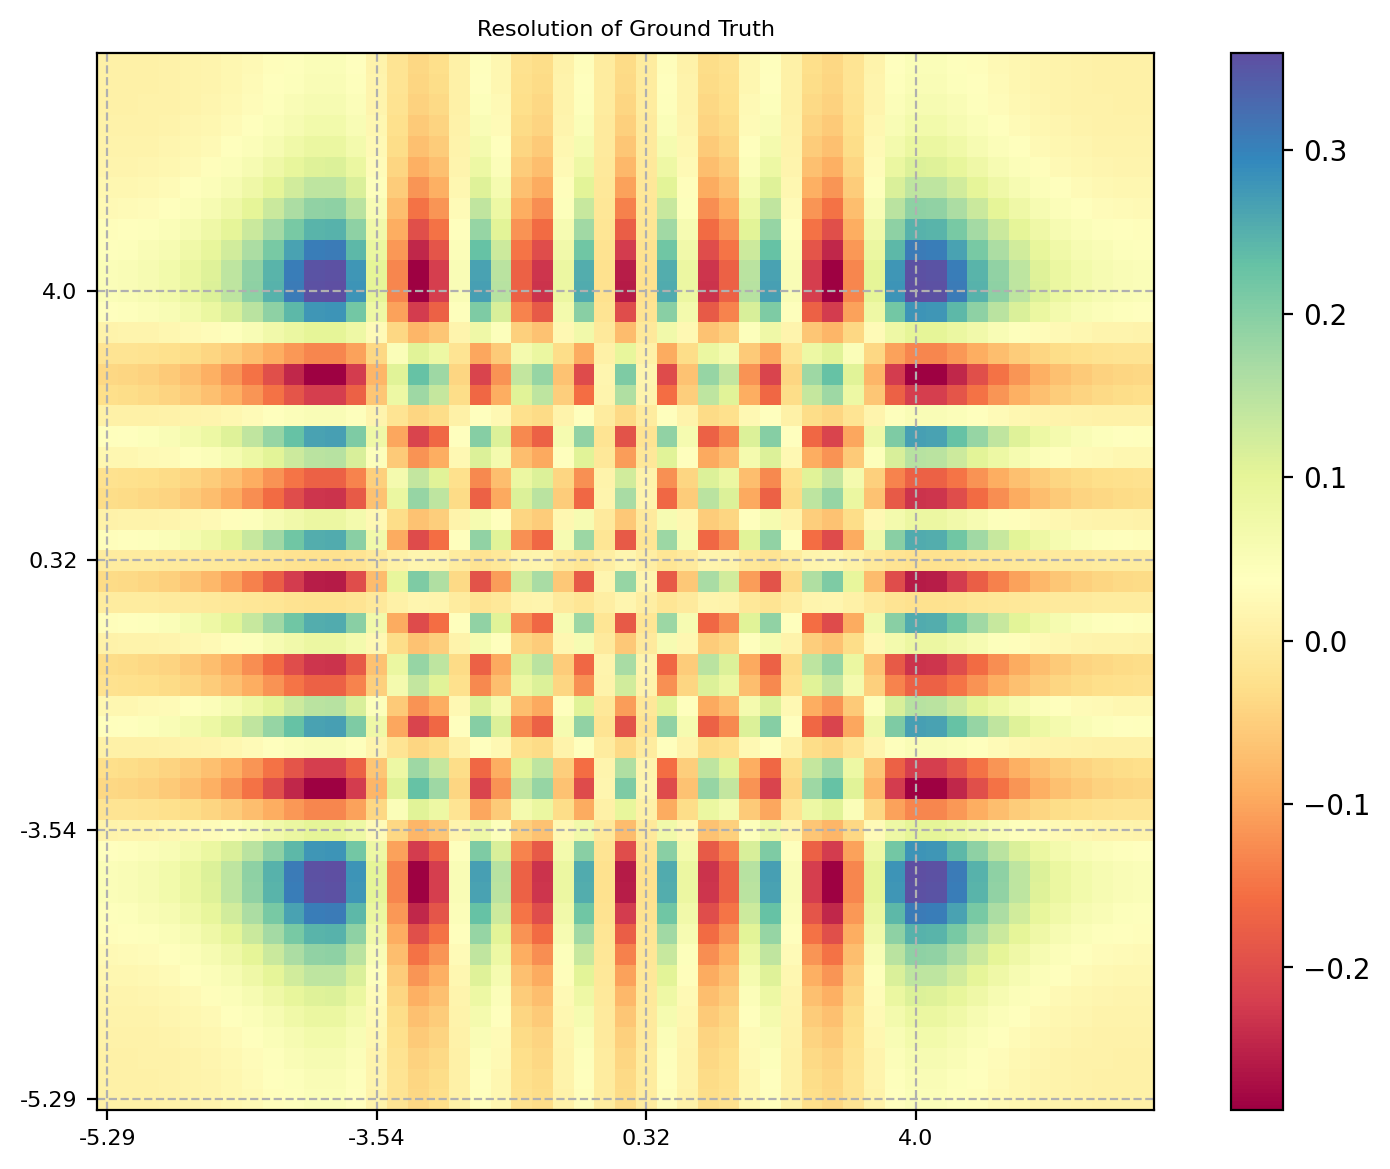

In [19]:
grid_2d = sob_2d.get_grid()
fn = "gt_resolution_qho"
solver.plot2d(gt(grid_2d[:,0], grid_2d[:,1]).reshape(len(xs_plt[0]),len(xs_plt[1])), xs_plt[0], xs_plt[1], title="Resolution of Ground Truth")#, file_name=fn)

In [27]:
# Analytic Gradient Flow
start = time.time()
KsK = 2*matmul(dmn.T, K.T, metric_2d(torch.mm(K, dmn)))\
        +2*matmul(bndr_0.T, metric_1d_0(bndr_0))\
        +2*matmul(bndr_1.T, metric_1d_1(bndr_1))

Ksf = 2*matmul(bndr_0.T, metric_1d_0(u_bndr_0))\
        +2*matmul(bndr_1.T, metric_1d_1(u_bndr_1))

w = matmul(KsK.inverse(), Ksf)
model.set_weights(w)
end = time.time()
print('time consumption: %.2fs' % (end-start))

time consumption: 0.98s


In [24]:
# Discrete Gradient Flow
optimizer = torch.optim.LBFGS(solver.model.parameters(), )
solver.train(100, 20, optim=optimizer)
print('time consumption: %.2fs' % solver.get_time())

epoch 20: loss = 0.0000000000000001
epoch 40: loss = 0.0000000000000001
epoch 60: loss = 0.0000000000000001
epoch 80: loss = 0.0000000000000001
epoch 100: loss = 0.0000000000000001
time consumption: 1.23s


### Benchmarks

In [25]:
# Plot Losses
#solver.plot_losses(lower=0, upper=-1)

pred rel. linf-error = 9.813130e-09
pred rel. l2-error = 2.250919e-09


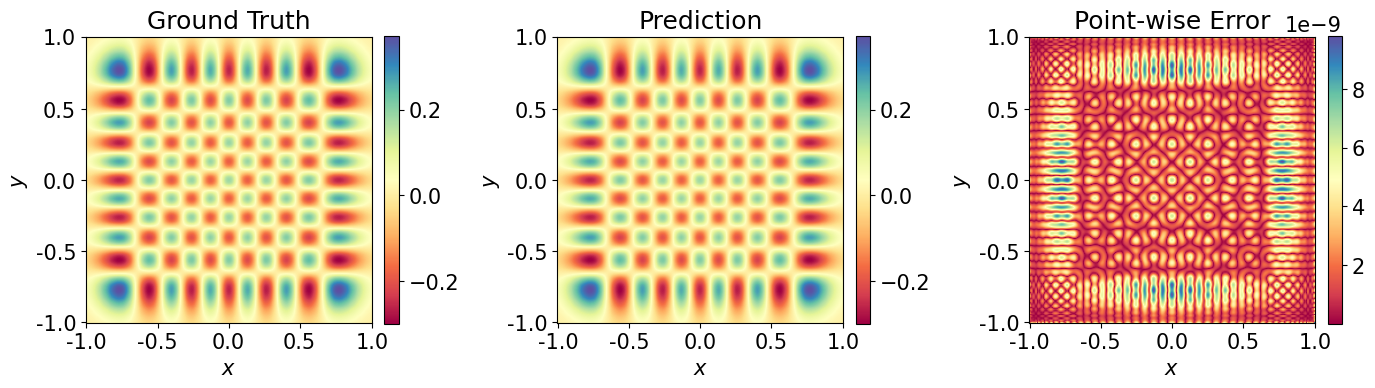

In [28]:
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcdefaults()
matplotlib.rcParams.update({'font.size': 15})
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
folder = r'/home/suarez08/PhD_PINNs/Benchmark_Dominik/Results_Dominik/'
x = test_xs[0]
y = test_xs[1]
Xt, Yt = np.meshgrid(test_xs[0],test_xs[1])
out = model(data).T[0].reshape(249,249).detach().numpy()
u_sol = gt(Xt,Yt)
#out = N_p()._eval(X_r).reshape(100,100)
L0_inf = np.max(abs(out-u_sol))
#Lp_inf = torch.max(abs(poisson_residual(net_s(inp_r),inp_r,omega).reshape(-1)))
L0_mean =np.mean(abs(out-u_sol))
print("pred rel. linf-error = {:e}".format(L0_inf))
print("pred rel. l2-error = {:e}".format(L0_mean))
#print("pde res. linf-error = {:e}".format(Lp_inf))
xl = np.linspace(-1,1, 5)
x_ticks = np.around(xl, 1)
plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.clim(-0.3,0.4)
plt.xticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.yticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
plt.xticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.yticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol), cmap="Spectral", origin="lower")
#plt.clim(np.min(np.abs(out-u_sol)/np.max(np.abs(u_sol))),np.max(np.abs(out-u_sol)/np.max(np.abs(u_sol))))
plt.xticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.yticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.colorbar(fraction=0.046, pad=0.04)

plt.gcf().set_size_inches(14,4)
plt.tight_layout()
plt.savefig(folder + 'L_inf_error.png')
#plt.savefig(folder + 'pred_error_MSE.png',bbox_inches='tight')

## Forward problem 

In [29]:
w_1d = sob_1d_0.get_leja_weights()
w_1d = torch.cat([w_1d,w_1d])
W_1d = torch.diag(w_1d)
w = sob_2d.get_leja_weights()
W = torch.diag(w)

In [32]:
start = time.time()
# Surrogate Model
model = surrogates.Polynomial(
    n=50,
    p=np.inf,
    dim=2,
    scale=[np.max(np.abs(rect[0])), np.max(np.abs(rect[1]))])
dt = 1
model.set_weights_val(0.1)
gt_ = gt(_x, _y)
th_0 = list(model.parameters())[0][0].detach().numpy()
th_t1 = torch.tensor(th_0)
grad_b0 = torch.matmul(bndr_0.T,torch.matmul(W_1d,bndr_0))
grad_b1 = torch.matmul(bndr_1.T,torch.matmul(W_1d,bndr_1))
K = torch.matmul(-0.5*(dx2+dy2)+0.5*op1-op2, dmn)
grad_dmn = matmul(K.T, torch.matmul(W,K))
grad_rec = (torch.eye(len(W))+torch.matmul(dmn.T,torch.matmul(W,dmn)))
#rhs_rec = torch.matmul(bndr_0.T,w_1d*gt_)
inv_op = (torch.eye(len(W))+2*dt*(grad_dmn+grad_b0+grad_b1)).inverse()
rhs_0 = 2*dt*torch.matmul(bndr_0.T,w_1d*u_bndr_0)
rhs_1 = 2*dt*torch.matmul(bndr_1.T,w_1d*u_bndr_1)
for k in range(1000):
    th_t = (torch.matmul(inv_op,th_t1+rhs_0+rhs_1))
    th_t1 = th_t
    model.set_weights(torch.tensor(th_t))
end = time.time()
print('time consumption: %.2fs' % (end-start))

/tmp/ipykernel_2840/2725314341.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.set_weights(torch.tensor(th_t))


time consumption: 2.31s


pred rel. linf-error = 1.444386e-08
pred rel. l2-error = 1.041395e-09


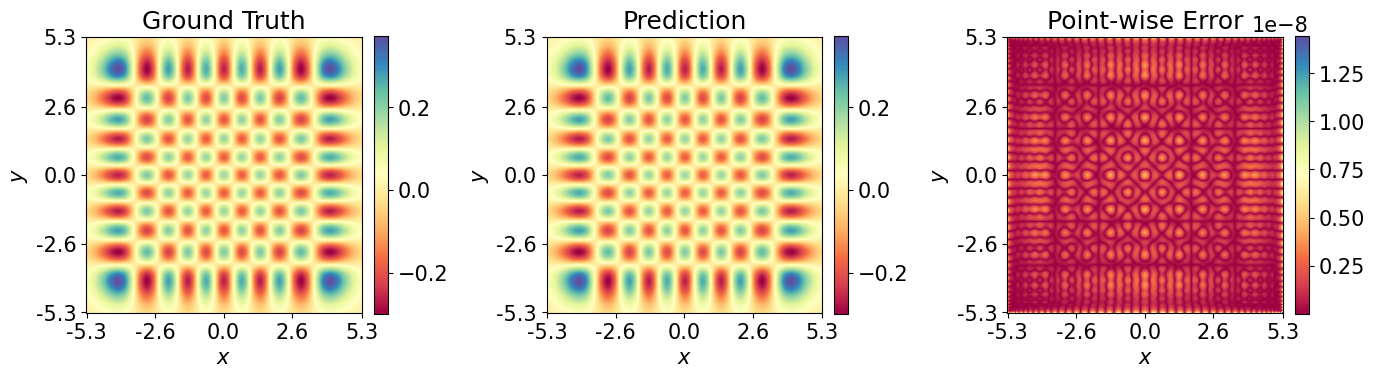

In [33]:
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcdefaults()
matplotlib.rcParams.update({'font.size': 15})
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
folder = r'/home/suarez08/PhD_PINNs/Benchmark_Dominik/Results_Dominik/'
x = test_xs[0]
y = test_xs[1]
Xt, Yt = np.meshgrid(test_xs[0],test_xs[1])
out = model(data).T[0].reshape(249,249).detach().numpy()
u_sol = gt(Xt,Yt)
#out = N_p()._eval(X_r).reshape(100,100)
L0_inf = np.max(abs(out-u_sol))
#Lp_inf = torch.max(abs(poisson_residual(net_s(inp_r),inp_r,omega).reshape(-1)))
L0_mean =np.mean(abs(out-u_sol))
print("pred rel. linf-error = {:e}".format(L0_inf))
print("pred rel. l2-error = {:e}".format(L0_mean))
#print("pde res. linf-error = {:e}".format(Lp_inf))
xl = np.linspace(-5.3,5.3, 5)
x_ticks = np.around(xl, 1)
plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.clim(-0.3,0.4)
plt.xticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.yticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
plt.xticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.yticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol), cmap="Spectral", origin="lower")
#plt.clim(np.min(np.abs(out-u_sol)/np.max(np.abs(u_sol))),np.max(np.abs(out-u_sol)/np.max(np.abs(u_sol))))
plt.xticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.yticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.colorbar(fraction=0.046, pad=0.04)

plt.gcf().set_size_inches(14,4)
plt.tight_layout()
plt.savefig(folder + 'L_inf_error.png')
#plt.savefig(folder + 'pred_error_MSE.png',bbox_inches='tight')